# Tutorial One - Data Preparation

This tutorial gives an overview of two methods of preparing sample data for use in the tutorial notebooks demonstrating the use of each scoring function. The result of this tutorial will be two files - "forecast_grid.nc" and "analysis_grid.nc". The two methods covered will be 

1. data download from the Austration National Computational Infrastructure, 
2. generation of synthetic data. 

Weather prediction data is typically large in size, and comes in many formats and structures. Common structures will include:

 - a single value for a prediction such as predicted maximum temperature (e.g. "The forecast for your town tomorrow is a maximum of 25 degrees"); 
 - a data array representing that value across a geographical area (such as a region, a country or the whole planet); 
 - a data array representing multiple possible predicted values (arising from ensemble predictions), or an expected value and confidence intervals. 

There is often also a time dimension to the data.

The data in the `scores` tutorials starts with typical numerical model data outputs and ensembles. This will be made clearer with an example.

Downloaded data is usually covered by a license agreement. You should check the license agreements for the downloaded data in these examples.

In [8]:
import hashlib     # Used to check the downloaded file is what is expected
import matplotlib  # Used to improve plot outputs
import numpy       # Used if generating synthetic data
import os          # Used to check if files are already downloaded
import pandas      # Used if generating synthetic data
import requests    # Used to retrieve files
import xarray      # Used for opening and inspecting the data

## Method One - Downloaded Data from the Australian National Computational Infrastructure

- This information was collected on 13 April 2023
- Information about the data can be found at geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#metadata/f5394_0782_5339_8313
- The DOI for this dataset is https://dx.doi.org/10.25914/608a9940ce85d
- The license listed for this dataset is Creative Commons Attribution 4.0 International (https://creativecommons.org/licenses/by/4.0)


In [9]:
# This is a basic file fetch only. Do not rely on it for untrusted data. A basic check has been included to make sure the
# downloaded file matches what was expected.

# tweak chunk_size if fetch is taking time
def basic_fetch(url, filename, expected_hash, *, chunk_size=8192):
    if os.path.exists(filename):
        print("File already exists, skipping download")
    else:    
        digest = hashlib.sha256()
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get("content-length", 0))
            downloaded = 0
            print(f"downloading {url} -> {filename}\n(size={total_size} bytes), please wait a moment...")
            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size):
                    f.write(chunk)
                    # update digest on the fly
                    digest.update(chunk)
                    downloaded += len(chunk)
        print("Download complete, checking digest...")
                    
        # check sha256 hash
        found_hash = digest.hexdigest()
        print(f"Hash validation: \n-> expected | {expected_hash}\n-> found    | {found_hash}") 
        if found_hash != expected_hash:
            os.remove(filename)
            print("File has unexpected contents. The file has been removed - please download manually and check the data carefully")
        print("Done.")

In [10]:
forecast_url = 'https://thredds.nci.org.au/thredds/fileServer/wr45/ops_aps3/access-g/1/20221120/0000/fc/sfc/temp_scrn.nc'
forecast_hash = '7956d95ea3a7edee2a01c989b1f9e089199da5b1924b4c2d4611088713fbcb44'  # Recorded on 13/5/2023
analysis_url = 'https://thredds.nci.org.au/thredds/fileServer/wr45/ops_aps3/access-g/1/20221124/0000/an/sfc/temp_scrn.nc'
analysis_hash = '163c5de55e721ad2a76518242120044bedfec805e3397cfb0008435521630042'  # Recorded on 13/5/2023

In [11]:
%%time
basic_fetch(forecast_url, 'forecast_grid.nc', forecast_hash)

File already exists, skipping download
CPU times: user 49 μs, sys: 17 μs, total: 66 μs
Wall time: 70.3 μs


In [12]:
%%time
basic_fetch(analysis_url, 'analysis_grid.nc', analysis_hash)

File already exists, skipping download
CPU times: user 116 μs, sys: 53 μs, total: 169 μs
Wall time: 436 μs


In [14]:
forecast = xarray.open_dataset('forecast_grid.nc', decode_timedelta=True)
forecast.temp_scrn

<xarray.DataArray 'temp_scrn' (time: 240, lat: 1536, lon: 2048)> Size: 3GB
[754974720 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2kB 2022-11-20T01:00:00 ... 2022-11-30
  * lat      (lat) float64 12kB 89.94 89.82 89.71 89.59 ... -89.71 -89.82 -89.94
  * lon      (lon) float64 16kB 0.08789 0.2637 0.4395 ... 359.6 359.7 359.9
Attributes:
    grid_type:   spatial
    level_type:  single
    units:       K
    long_name:   screen level temperature
    stash_code:  3236
    accum_type:  instantaneous

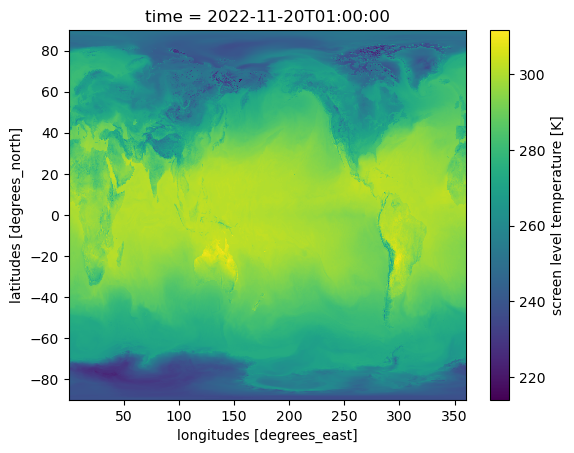

In [15]:
forecast.temp_scrn[0].plot()

In [16]:
# The forecast contains 240 hours of forecast data, spanning 20th November 2022 at 1am to 30 November 2022 at midnight.
print(len(forecast.time.values))
print(min(forecast.time.values))
print(max(forecast.time.values))

240
2022-11-20T01:00:00.000000000
2022-11-30T00:00:00.000000000


In [17]:
analysis = xarray.open_dataset('analysis_grid.nc', decode_timedelta=True)
analysis.temp_scrn

<xarray.DataArray 'temp_scrn' (time: 1, lat: 1536, lon: 2048)> Size: 13MB
[3145728 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 8B 2022-11-24
  * lat      (lat) float64 12kB 89.94 89.82 89.71 89.59 ... -89.71 -89.82 -89.94
  * lon      (lon) float64 16kB 0.08789 0.2637 0.4395 ... 359.6 359.7 359.9
Attributes:
    grid_type:   spatial
    level_type:  single
    units:       K
    long_name:   screen level temperature
    stash_code:  3236
    accum_type:  instantaneous

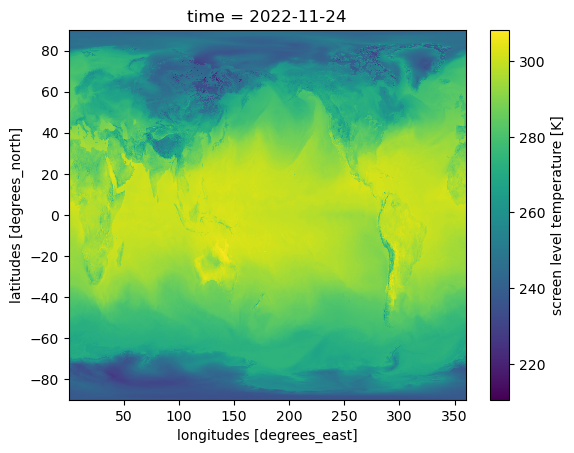

In [18]:
analysis.temp_scrn.plot()

In [19]:
# This is the analysis grid for midnight on the 24th of November 2022.
# This represents what happened, four days after the prediction was first made, and can be used to check accuracy
analysis.temp_scrn.time.values

array(['2022-11-24T00:00:00.000000000'], dtype='datetime64[ns]')

In [20]:
# This data extends from -90 degrees latitude to +90 degrees latitude, and from 0 to 360 degrees longitude.
# There are 1536 points of latitude, and 2048 points of longitude.
print(min(analysis.temp_scrn.lat.values))
print(max(analysis.temp_scrn.lat.values))
print(len(analysis.temp_scrn.lat.values))
print(min(analysis.temp_scrn.lon.values))
print(max(analysis.temp_scrn.lon.values))
print(len(analysis.temp_scrn.lon.values))

-89.94140600000904
89.941406
1536
0.087891
359.912109
2048


## Method Two - Synthetic Data

Synthetic data is easy to generate quickly, can be customised to focus on a specific example, and doesn't require any time to download. However, it can be less realistic and therefore may not capture the complexity of a real-world situation.

This method will generate an array of 240 x 1536 x 2048, closely matching the domain of the Australian ACCESS-G model, and write this to a file called "forecast_grid.nc". It will then generate another array of 1x1536x2048 and write this to a file called "analysis_grid.nc". These files can then substitute to a greater or lesser degree for the real-world data shown in the previous step. There may be some differences but it should be sufficient for demonstration purposes.

In [21]:
lat = numpy.linspace(-90, 90, 1536)
lon = numpy.linspace(0, 360, 2048)
slow_decrease = numpy.linspace(26, 18, 240)
time_series = pandas.date_range(start='2022-11-20T01:00:00.000000000',
                        end='2022-11-30T00:00:00.000000000',
                        periods=240)
analysis_time = [time_series[24*4-1].to_pydatetime()]  # November 24th at midnight

In [22]:
# We will use random noise to provide some variation to the data
random_number_generator = numpy.random.default_rng(seed=42)
random = random_number_generator.random((1, 1536, 2048)) 

In [ ]:
%%time
# The analysis step is around 24 degrees, plus some random noise. Ideally this would include some more structure.
analysis_values = random + 24  

# The forecast contains a slowly decreasing trend on average which will give us some difference for comparison
forecast_values = numpy.array([random[0] + trend for trend in slow_decrease])

In [ ]:
analysis_array = xarray.DataArray(coords={'time': analysis_time, 'lat': lat, 'lon': lon, }, data=analysis_values)
analysis = xarray.Dataset(data_vars={'temp_scrn': analysis_array})
analysis.to_netcdf('analysis_grid.nc')
analysis

In [ ]:
analysis.temp_scrn.plot()

In [ ]:
forecast_array = xarray.DataArray(coords={'time': time_series, 'lat': lat, 'lon': lon, }, data=forecast_values)
forecast = xarray.Dataset(data_vars={'temp_scrn': forecast_array})
forecast.to_netcdf('forecast_grid.nc')
forecast

In [ ]:
forecast.temp_scrn[0].plot(cmap=matplotlib.pyplot.cm.Blues, vmin=22, vmax=27)
forecast.temp_scrn[0].mean()

In [ ]:
forecast.temp_scrn[24*4-1].plot(cmap=matplotlib.pyplot.cm.Blues, vmin=22, vmax=27)
forecast.temp_scrn[24*4-1].mean()